In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
gamma = "0.8"
path = "../boeing_test_medium/try1/%s" % gamma # path of CASC outputs
f = open("%s/motifs.pkl" % path, "rb")
m = pickle.load(f)
assigns = np.loadtxt("%s/assign.out" % path, delimiter=",")
datapath = "../boeing_data_files/boeing_medium.out" # path of sensor outputs
sampleEvery = 10
skipRow = lambda x: x % sampleEvery != 0
dataToKeep = ['t', 'Phase', 'ALTITUDE_1013_ADIRU', 'ALTITUDE_1013_SAARU',
              'SLATS_IN_LANDING_FSEU', 'SLATS_IN_TAKEOFF_FSEU',
              'flight_index', 'VERTICAL_SPEED_SAARU', 'GROUND_SPEED_ADIRU', 'FMF_GROUNDSPEED_NAV']
frame = pd.read_csv(datapath, sep='\t', skiprows=skipRow, usecols=dataToKeep)

In [19]:
def getSegments(start, end, assignment):
    values = []
    prev = start
    for i in range(start, end+1):
        if assignment[i] != assignment[prev]:
            values.append((prev, i))
            prev = i+1
    values.append((prev, i))
    return values

In [20]:
motiflist = sorted([(len(m[k]), k) for k in m.keys()], reverse=True)
length, motif = motiflist[0]
print(length, motif)

def getValues(sensorName):
    values = [[] for _ in range(len(motif))]
    for start, end in m[(motif)]:
        segs = getSegments(start, end, assigns)
        for i, s in enumerate(segs):
            vals = frame[[sensorName]].loc[s[0]:s[1]].values.T.flatten()
            values[i].append(vals.mean())
    means = [np.mean(v) for v in values]
    stds = [np.std(v) for v in values]
    stds = np.array([np.std(v) for v in values]).flatten()
    return stds, means

41 (9, 6, 0, 7, 3, 4)


(9, 6, 0, 7, 3, 4)
[(1852, 2437), (3477, 4727), (17228, 17721), (20394, 20790), (22767, 23180), (27777, 28221), (28222, 29245), (29246, 30446), (33157, 33618), (35319, 35776), (37162, 38042), (38743, 39254), (39255, 39929), (39930, 40749), (52946, 53842), (57956, 58795), (72601, 73062), (84588, 85286), (90895, 91303), (105436, 105822), (108642, 109041), (120615, 121320), (121360, 122192), (124285, 125231), (127781, 128188), (139109, 140114), (142038, 142423), (144849, 145448), (147747, 148464), (148465, 150599), (152557, 152933), (153983, 154783), (154784, 155763), (156667, 157665), (176303, 176738), (179132, 180056), (180169, 180989), (182143, 183212), (183891, 185527), (192039, 192396), (193279, 194304)]


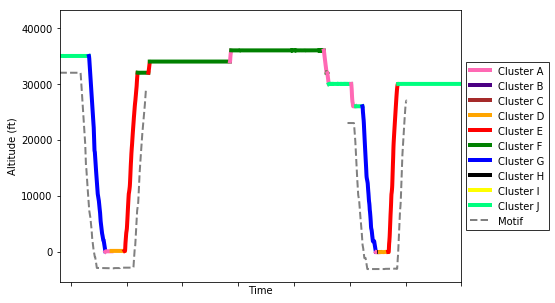

In [23]:
import operator

xmin = 149900
xmax = 153500

alts = frame[["ALTITUDE_1013_ADIRU"]].values.T.flatten()
# print(frame[xmin:xmax][["t"]])
labels = np.arange(len(alts))
colors = ['hotpink', 'indigo', 'brown', 'orange', 'red', 'green', 'blue', 'black', 'yellow', 'springgreen', 'salmon']
taken = [None]*10
old_c = 0
plt.figure(1, figsize=(9,5))
ax = plt.subplot(1,1,1)
for i in range(len(labels)):
    cluster = int(assigns[old_c])
    if assigns[i] != assigns[old_c]:
        if taken[cluster] is not None:
            labelValue = None
        else:
            labelValue = "Cluster %s" % chr(ord('A') + cluster)
            taken[cluster] = True
        ax.plot(labels[old_c:i], alts[old_c:i], color=colors[cluster], linewidth=4.0, label=labelValue)
        old_c = i
        
# plt.plot(labels, alts)
print(motif)
sortedsegs = sorted(list(m[(motif)]))
print(sortedsegs)
putLegend = False
for start, end in m[(motif)]:
    xaxis = labels[start:end+1]
    altvals = alts[start:end+1]
    mid= np.argmin(altvals)
    xaxis[: mid] = 0.9995*xaxis[: mid]
    xaxis[mid:] = 1.0005*xaxis[mid:]
    labelValue = None if putLegend else "Motif"
    putLegend = True
    ax.plot(xaxis, alts[start:end+1]-3000, '--', color="gray", linewidth=2.0, label=labelValue)
plt.xlim(xmin=xmin, xmax=xmax)
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.setp( ax.get_xticklabels(), visible=False)
plt.ylabel("Altitude (ft)")
plt.xlabel('Time')
ax.legend(handles2, labels2, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=False, edgecolor="black")
plt.rcParams.update({'font.size': 14})
plt.savefig('airplaneAltitude.eps', format='eps', bbox_inches='tight', dpi=1000)
plt.show()


[184.29178663 197.21567799   4.46650984   1.90769498 593.77864419
 594.37077267]


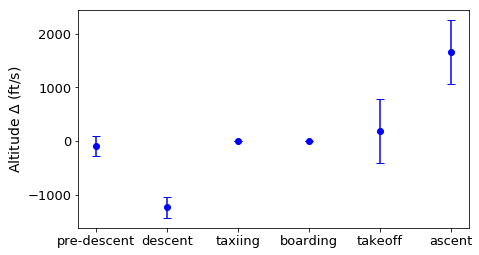

[ 64.26374121  31.37765355   2.39602498   1.59775928 107.68453823
  62.41643284]


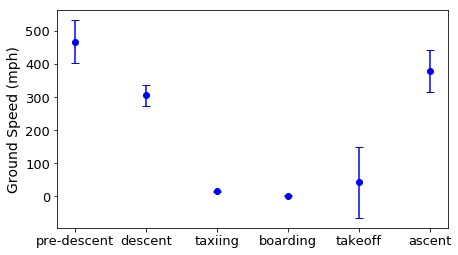

In [26]:
import matplotlib.pyplot as plt
from scipy import stats

def createErrorBarPlot(metric, axisTitle, plotTitle):
    stds, means = getValues(metric)
    errors = stds
    plt.figure(1, figsize=(7,4))
    plt.xticks([0, 1,2,3,4,5], ["pre-descent", "descent", "taxiing", "boarding", "takeoff", "ascent"])
    print(stds)
    plt.errorbar(np.arange(len(motif)), means, yerr=errors, fmt='bo', capsize=4)
    plt.ylabel(axisTitle)
    plt.rcParams.update({'font.size': 14})
    plt.tick_params(labelsize = 13)
    plt.savefig(plotTitle, format='eps', bbox_inches='tight', dpi=1000)
    plt.show()
createErrorBarPlot("VERTICAL_SPEED_SAARU", 'Altitude $\Delta$ (ft/s)', "verticalSpeed.eps")
createErrorBarPlot("GROUND_SPEED_ADIRU", 'Ground Speed (mph)', "groundSpeed.eps")
